In [2]:
from dcase_evaluator import DCASEEvaluator
from models.audiosep import AudioSep
from models.one_peace_encoder import ONE_PEACE_Encoder

import argparse
import os
from utils import parse_yaml, load_ss_model
import torch
import numpy as np

import librosa
import pandas as pd
import soundfile as sf
import scipy.io.wavfile as wf
from scipy.io import wavfile
from scipy.signal import spectrogram
from tqdm import tqdm
import matplotlib.pyplot as plt

/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/nfshomes/vla/lass-final-project/models/CLAP/open_clip/factory.py:55: FutureWarning: You a

In [3]:
# Generate and plot the spectrogram
def plot_spectrograms(source, sep_segment, sample_rate, name):
    # Load the audio file
    # sample_rate, data = load_wav(file_path)
    
    # Generate spectrogram for mixture source audio
    frequencies, times, Sxx = spectrogram(source, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')
    plt.colorbar(label='Power (dB)')
    plt.title('Mixture')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()

    plt.savefig(f'{name}_mixture_spectrogram')
    plt.show()

    vmax = source_cmesh.colorbar.norm.vmax
    vmin = source_cmesh.colorbar.norm.vmin

    # Generate spectrogram for mixture source audio
    frequencies, times, Sxx = spectrogram(sep_segment, fs=sample_rate)
    
    # Plot spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',
                   vmin=vmin, vmax=vmax)
    
    plt.colorbar(label='Power (dB)')
    plt.title('Separation Result')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.savefig(f'{name}_sep_spectrogram')
    plt.show()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config_yaml = 'config/audiosep_onepeace.yaml'
encoder_checkpoint_path = '/fs/nexus-scratch/vla/finetune_al_retrieval.pt'

# NOTE: best checkpoint on validation set
ssnet_checkpoint_path = '/fs/nexus-scratch/vla/checkpoints/train/audiosep_onepeace,devices=1/step=140000.ckpt'
sampling_rate=16000
configs = parse_yaml(config_yaml)

# ONE_PEACE modelhub expects some paths to be relative to this dir
os.chdir('ONE-PEACE/')
# TODO:path in shared scratch dir for now..., move to class project dir whenever we get that
query_encoder = ONE_PEACE_Encoder(pretrained_path=encoder_checkpoint_path)
os.chdir('..')

# put ONE-PEACE model in eval model (probably unecessary)
query_encoder.model.model.eval()

pl_model = load_ss_model(
    configs=configs,
    checkpoint_path=ssnet_checkpoint_path,
    query_encoder=query_encoder
).to(device)

/fs/nexus-scratch/vla/micromamba/envs/LASS/lib/python3.9/site-packages/fairseq/checkpoint_utils.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f, m

## REAL Evaluation (Test) Set

In [5]:
eval_csv = 'lass_real_evaluation.csv'
dict_eval = pd.read_csv(eval_csv).set_index('file_name').to_dict()['query']
output_dir = 'lass_evaluation_real_output'
audio_dir = 'lass_evaluation_real'

In [6]:
test_samples = [i for i in range(200)]
filenames = [os.path.join(f'test-real-case-{s}.wav') for s in test_samples]

gather = []
with torch.no_grad():
    for i, filename in enumerate(tqdm(filenames)):
        
        # load audio from test set
        input_path = os.path.join(audio_dir, filename)
        source, fs = librosa.load(input_path, sr=sampling_rate, mono=True)

        # compute text embedding with ONE-PEACE query encoder
        conditions = pl_model.query_encoder.get_query_embed(
                        modality='text',
                        text=[dict_eval[filename]],
                        device=device 
        )

        input_dict = {
                        "mixture": torch.Tensor(source)[None, None, :].to(device),
                        "condition": conditions,
                    } 

        # output audio
        sep_segment = pl_model.ss_model(input_dict)["waveform"]

        # TODO: compute ONE-PEACE embedding on sep_segment and dot w/ conditions for comparison in embedding space
        # sep_segment_embd = pl_model.query_encoder.model
        # sep_segment: (batch_size=1, channels_num=1, segment_samples)
        sep_segment = sep_segment.squeeze(0).squeeze(0).data.cpu().numpy()


        # write out .wav file
        output_path = os.path.join(output_dir, filename)
        wf.write(output_path, sampling_rate, sep_segment)

        similarities = dict(
            filename = filename
        )

        # COMPUTE SIMILARITIES
        src_audios, audio_padding_masks = pl_model.query_encoder.model.process_audio([input_path])
        audio_features = pl_model.query_encoder.model.extract_audio_features(src_audios, audio_padding_masks)
        input_similarity = conditions @ audio_features.T
        similarities['input_similarity'] = input_similarity.squeeze(0).cpu().numpy()[0]
        # print(f'Text Prompt - Mixed Audio Input Similarity: {input_similarity}')

        src_audios, audio_padding_masks = pl_model.query_encoder.model.process_audio([output_path])
        audio_features = pl_model.query_encoder.model.extract_audio_features(src_audios, audio_padding_masks)
        output_similarity = conditions @ audio_features.T
        similarities['output_similarity'] = output_similarity.squeeze(0).cpu().numpy()[0]
        # print(f'Text Prompt - Seperated Audio Output Similarity: {output_similarity}')

        gather.append(similarities)


100%|██████████| 200/200 [01:14<00:00,  2.67it/s]


In [7]:
def plot_spectrogram_by_idx(idx, filenames):

    filename = filenames[idx]

    with torch.no_grad():
        # load audio from test set
        input_path = os.path.join(audio_dir, filename)
        source, fs = librosa.load(input_path, sr=sampling_rate, mono=True)


        # compute text embedding with ONE-PEACE query encoder
        conditions = pl_model.query_encoder.get_query_embed(
                        modality='text',
                        text=[dict_eval[filename]],
                        device=device 
        )

        input_dict = {
                        "mixture": torch.Tensor(source)[None, None, :].to(device),
                        "condition": conditions,
                    } 

        # output audio
        sep_segment = pl_model.ss_model(input_dict)["waveform"]

        # TODO: compute ONE-PEACE embedding on sep_segment and dot w/ conditions for comparison in embedding space
        # sep_segment_embd = pl_model.query_encoder.model
        # sep_segment: (batch_size=1, channels_num=1, segment_samples)
        sep_segment = sep_segment.squeeze(0).squeeze(0).data.cpu().numpy()

        plot_spectrograms(source, sep_segment, sampling_rate, str(idx))

        

/tmp/ipykernel_615890/197981830.py:11: RuntimeWarning: divide by zero encountered in log10
  source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')


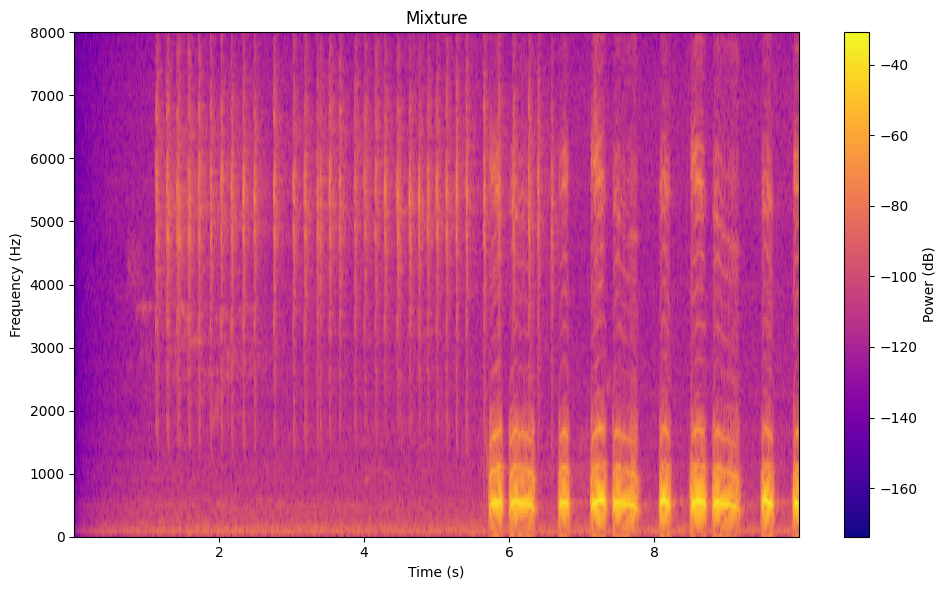

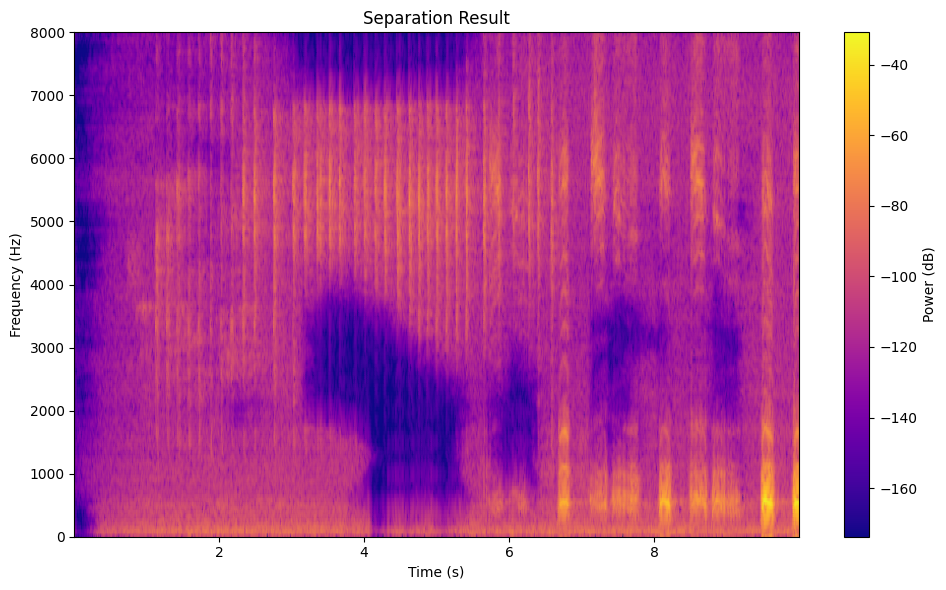

In [8]:
# new
plot_spectrogram_by_idx(28, filenames)

/tmp/ipykernel_615890/197981830.py:11: RuntimeWarning: divide by zero encountered in log10
  source_cmesh = plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma')


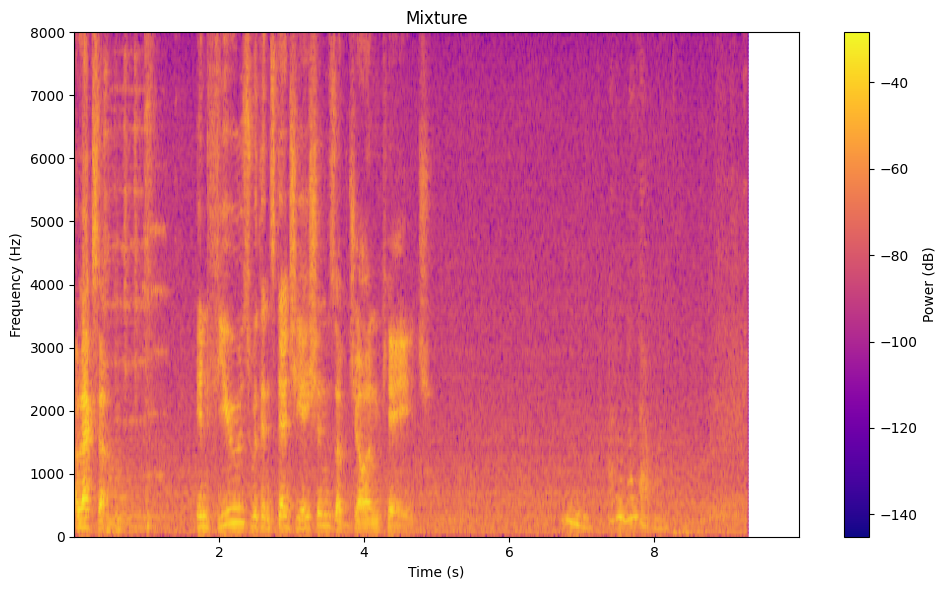

/tmp/ipykernel_615890/197981830.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap = 'plasma',


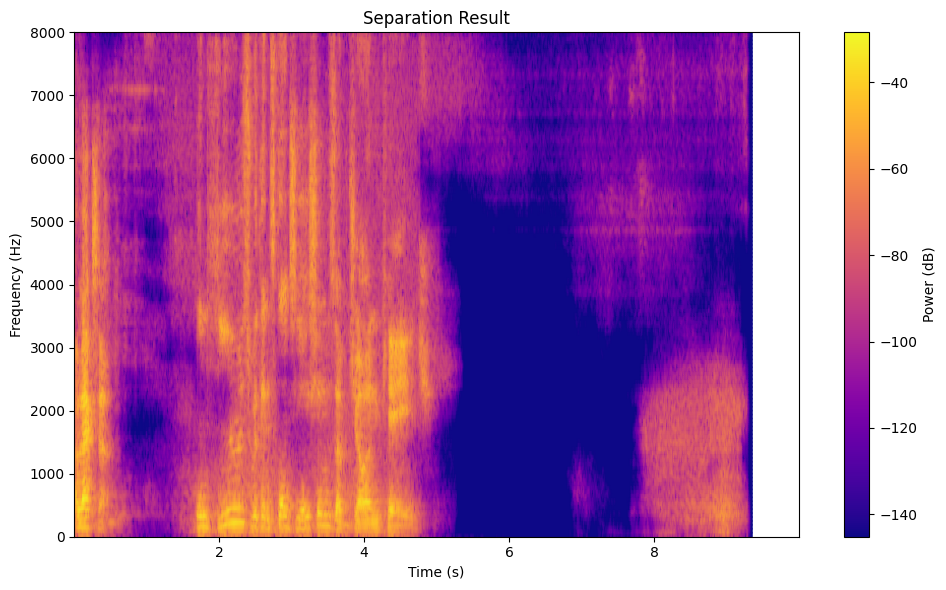

In [9]:
plot_spectrogram_by_idx(89, filenames)

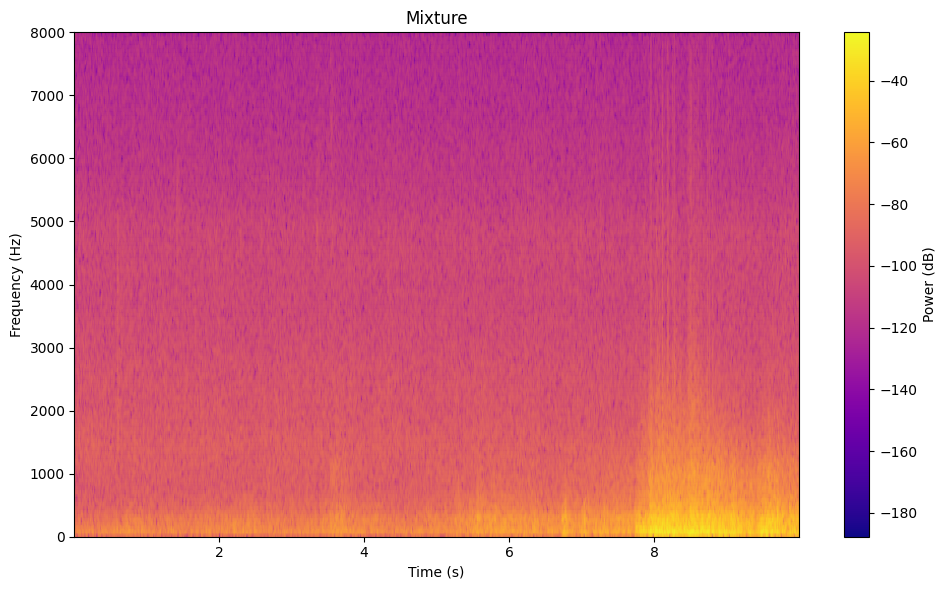

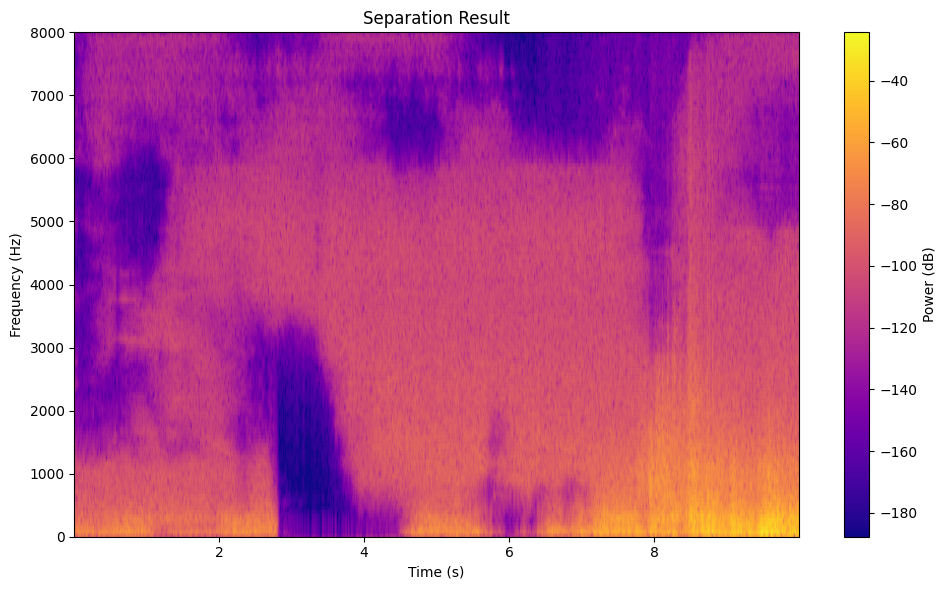

In [11]:
plot_spectrogram_by_idx(157, filenames)

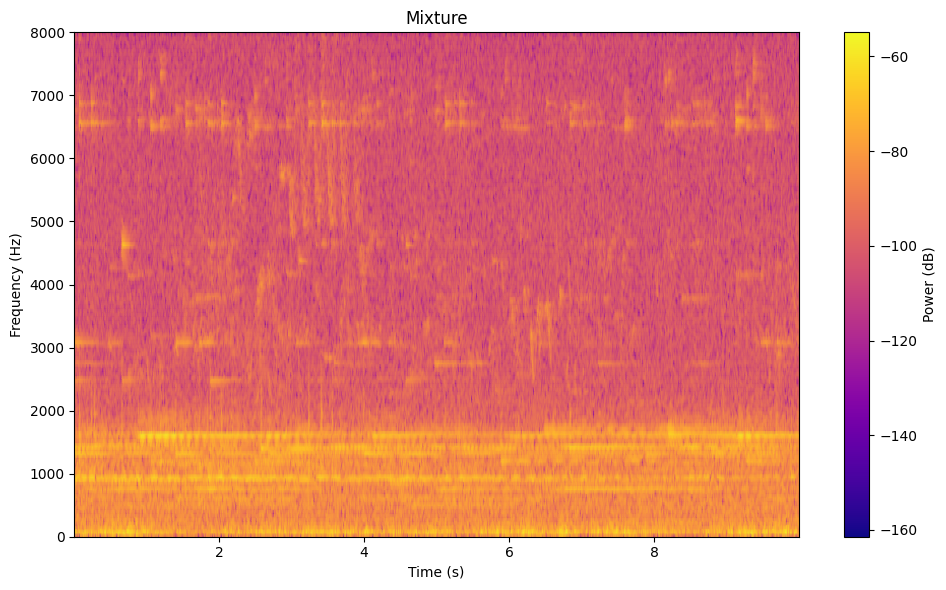

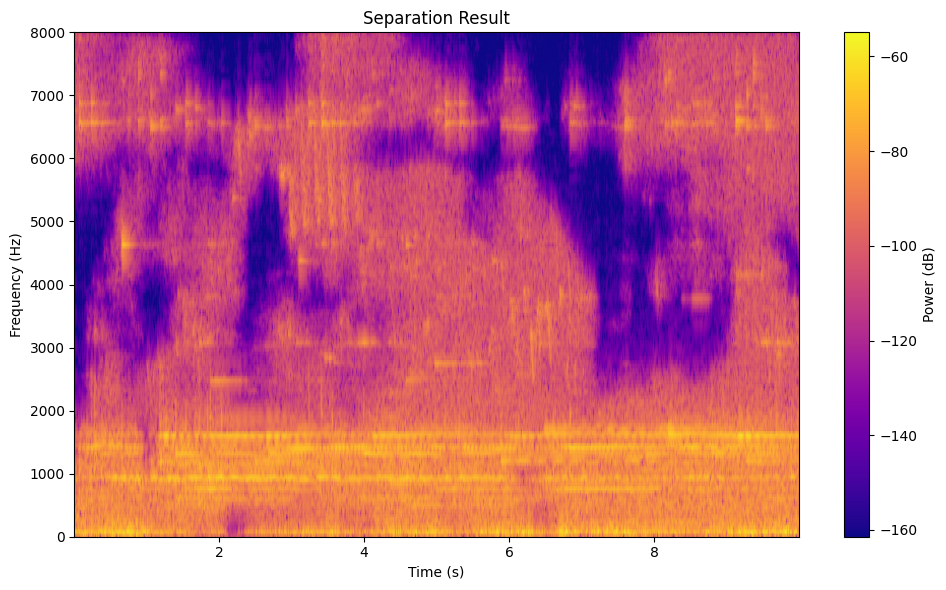

In [12]:
plot_spectrogram_by_idx(73, filenames)

In [16]:
df = pd.DataFrame(gather)
df['delta_similarity'] = df.output_similarity - df.input_similarity
df['text_prompt'] =  [dict_eval[row_dict['filename']] for row_dict in df.to_dict('records')]

pd.set_option('display.max_colwidth', 255)
df[:5]

filename  input_similarity  output_similarity  \
0  test-real-case-0.wav          0.353481           0.178797   
1  test-real-case-1.wav          0.408589           0.174875   
2  test-real-case-2.wav          0.299390           0.418810   
3  test-real-case-3.wav          0.306068           0.405644   
4  test-real-case-4.wav          0.186258           0.268531   

   delta_similarity  \
0         -0.174684   
1         -0.233713   
2          0.119420   
3          0.099576   
4          0.082273   

                                                              text_prompt  
0  the fire crackles in the wind, creating a rhythmic and soothing sound.  
1                            the fire is making crackling sounds at home.  
2                     the wind chimes are making a crisp and sweet sound.  
3                                 the wind chime is ringing continuously.  
4                          a group of people are talking with each other.

In [15]:
# Top 10 increase in similarity
df.sort_values(by = 'delta_similarity', ascending=False)[:20]

filename  input_similarity  output_similarity  \
89    test-real-case-89.wav          0.032961           0.290351   
12    test-real-case-12.wav         -0.033668           0.179707   
92    test-real-case-92.wav          0.249867           0.453241   
47    test-real-case-47.wav          0.200838           0.374104   
99    test-real-case-99.wav          0.267578           0.429304   
39    test-real-case-39.wav          0.089535           0.247839   
67    test-real-case-67.wav          0.132676           0.283462   
53    test-real-case-53.wav          0.212885           0.359864   
117  test-real-case-117.wav          0.064358           0.209792   
80    test-real-case-80.wav          0.130410           0.272690   
196  test-real-case-196.wav          0.139623           0.279716   
71    test-real-case-71.wav          0.281877           0.410634   
35    test-real-case-35.wav          0.059189           0.187104   
93    test-real-case-93.wav          0.221970           0.347608   
46    test-real-case-46.wav          0.237846           0.361615   
176  test-real-case-176.wav          0.294209           0.413647   
2      test-real-case-2.wav          0.299390           0.418810   
118  test-real-case-118.wav          0.189310           0.308370   
69    test-real-case-69.wav          0.150574           0.265674   
142  test-real-case-142.wav          0.096658           0.210543   

     delta_similarity  \
89           0.257391   
12           0.213375   
92           0.203374   
47           0.173266   
99           0.161726   
39           0.158304   
67           0.150786   
53           0.146979   
117          0.145435   
80           0.142279   
196          0.140093   
71           0.128758   
35           0.127915   
93           0.125637   
46           0.123769   
176          0.119438   
2            0.119420   
118          0.119060   
69           0.115100   
142          0.113885   

                                                           text_prompt  
89               a man is delivering a speech passionately and loudly.  
12                                the woman is speaking in a distance.  
92              something is falling to the ground and making a clank.  
47                               a little kid is screaming and crying.  
99   the siren is ringing and gradually fading into the roadway noise.  
39                             lots of birds are chirping in the wild.  
67         a group of people are cheering loudly and enthusiastically.  
53                                 the waves are surging in the ocean.  
117                      someone is trying to making the engine start.  
80                  in the forest, the birds are chirping incessantly.  
196        in a noisy environment, the birds are chirping incessantly.  
71                            the waves are beating against the shore.  
35                 in the forest, the birds are chirping incessantly.   
93            some metalwork tumbles to the floor with a loud clatter.  
46                               there is a child crying and shouting.  
176            the water is dribbling and emitting echoes in the room.  
2                  the wind chimes are making a crisp and sweet sound.  
118        in a noisy environment, the birds are chirping incessantly.  
69    someone is playing drum kit to make rhythmic and dynamic sounds.  
142                            the sound of human voices keeps coming.

In [ ]:
# Top 10 output_similarity
df.sort_values(by = 'output_similarity', ascending=False)[:20]

filename  input_similarity  output_similarity  \
73    test-real-case-73.wav          0.527743           0.554807   
157  test-real-case-157.wav          0.599794           0.553626   
55    test-real-case-55.wav          0.484623           0.551696   
54    test-real-case-54.wav          0.490684           0.547102   
109  test-real-case-109.wav          0.530180           0.537120   
79    test-real-case-79.wav          0.454269           0.533323   
62    test-real-case-62.wav          0.485529           0.531196   
150  test-real-case-150.wav          0.447738           0.529801   
146  test-real-case-146.wav          0.535385           0.528384   
147  test-real-case-147.wav          0.536872           0.509338   
78    test-real-case-78.wav          0.466396           0.508955   
141  test-real-case-141.wav          0.532784           0.506604   
20    test-real-case-20.wav          0.403465           0.505912   
44    test-real-case-44.wav          0.518872           0.505004   
139  test-real-case-139.wav          0.535695           0.503754   
140  test-real-case-140.wav          0.499219           0.503063   
199  test-real-case-199.wav          0.492470           0.493269   
72    test-real-case-72.wav          0.547434           0.487443   
82    test-real-case-82.wav          0.566679           0.485657   
144  test-real-case-144.wav          0.580971           0.484152   

     delta_similarity  \
73           0.027064   
157         -0.046168   
55           0.067073   
54           0.056417   
109          0.006939   
79           0.079054   
62           0.045666   
150          0.082063   
146         -0.007000   
147         -0.027534   
78           0.042559   
141         -0.026179   
20           0.102447   
44          -0.013867   
139         -0.031941   
140          0.003843   
199          0.000799   
72          -0.059990   
82          -0.081022   
144         -0.096819   

                                                                                                 text_prompt  
73                                        the wind chime is ringing with a jingling sound as the wind blows.  
157                                                                         the thunder is heavily rumbling.  
55                                          someone is playing the drum to make rhythmic and dynamic sounds.  
54                                                    someone is beating the drum, making a wonderful sound.  
109                                                                   some people are clapping and cheering.  
79                                                                  the bike's bell is making a crisp sound.  
62                                    the fire crackles in the wind, creating a rhythmic and soothing sound.  
150                                             the wind chime is swaying and ringing with a jingling sound.  
146                                                       there are plenty of wind chimes clashing together.  
147                                        the wind chimes keep swinging and making a clear and crisp sound.  
78                                                                  the bicycle bell is ringing and echoing.  
141                                                                           a group of ducks are quacking.  
20                                                                 thunder is raging and rumbling from afar.  
44                             the crowd is chanting and yelling, whose sound is becoming louder and louder.  
139                                                                             the crow keeps making noise.  
140                                                                          the ducks are quacking nonstop.  
199                                   a group of people are shouting slogans and then talking to each other.  
72                             with the blowing of wind, the wind 

In [ ]:
# top 10 input_similarity
df.sort_values(by = 'input_similarity', ascending=False)[:20]

filename  input_similarity  output_similarity  \
157  test-real-case-157.wav          0.599794           0.553626   
144  test-real-case-144.wav          0.580971           0.484152   
82    test-real-case-82.wav          0.566679           0.485657   
145  test-real-case-145.wav          0.559296           0.420106   
95    test-real-case-95.wav          0.556390           0.380181   
119  test-real-case-119.wav          0.549892           0.141586   
72    test-real-case-72.wav          0.547434           0.487443   
147  test-real-case-147.wav          0.536872           0.509338   
139  test-real-case-139.wav          0.535695           0.503754   
146  test-real-case-146.wav          0.535385           0.528384   
94    test-real-case-94.wav          0.533911           0.361768   
141  test-real-case-141.wav          0.532784           0.506604   
109  test-real-case-109.wav          0.530180           0.537120   
73    test-real-case-73.wav          0.527743           0.554807   
45    test-real-case-45.wav          0.521976           0.450611   
74    test-real-case-74.wav          0.521018           0.314077   
44    test-real-case-44.wav          0.518872           0.505004   
23    test-real-case-23.wav          0.516792           0.404581   
138  test-real-case-138.wav          0.507794           0.455270   
22    test-real-case-22.wav          0.503387           0.387854   

     delta_similarity  \
157         -0.046168   
144         -0.096819   
82          -0.081022   
145         -0.139190   
95          -0.176208   
119         -0.408306   
72          -0.059990   
147         -0.027534   
139         -0.031941   
146         -0.007000   
94          -0.172143   
141         -0.026179   
109          0.006939   
73           0.027064   
45          -0.071365   
74          -0.206941   
44          -0.013867   
23          -0.112211   
138         -0.052524   
22          -0.115533   

                                                                                                 text_prompt  
157                                                                         the thunder is heavily rumbling.  
144           the persistent chirping of crickets in the grass intensifies the natural harmony of the night.  
82   the crickets in the grass are making a constant buzzing sound, adding to the evening's natural harmony.  
145                                                     lots of crickets are chirping together in the grass.  
95                                                                                the dog is barking loudly.  
119                                                                            a rooster is crowing at dawn.  
72                             with the blowing of wind, the wind chimes are making a crisp and sweet sound.  
147                                        the wind chimes keep swinging and making a clear and crisp sound.  
139                                                                             the crow keeps making noise.  
146                                                       there are plenty of wind chimes clashing together.  
94                                                            a fierce dog is barking continuously outdoors.  
141                                                                           a group of ducks are quacking.  
109                                                                   some people are clapping and cheering.  
73                                        the wind chime is ringing with a jingling sound as the wind blows.  
45                                                                 a bunch of people are cheering in unison.  
74                                                as the two women chat, their silverware clatters together.  
44                             the crowd is chanting and yelling, whose sound is becoming louder and louder.  
23                                                the crowd is cla